# New plotting classes have been added to flopy

these classes seamlessly support vertex model grid cross section plotting using the new `PlotCrossSection` class. This class will replace the previous `ModelCrossSection` class; however backward compatibility is still supported through `ModelCrossSection`.

`PlotCrossSection` has a similar interface as `ModelCrossSection`. In most instances the two classes can be used interchangably. The biggest difference is that some of the input parameters have changed.

The number of input parameters to the `PlotCrossSection` class has been reduced to make it easier to work with.

Transforms using `xll`, `yll`, `xul`, `yul`, `rotation`, and `length_multiplier` have been removed from the list of parameters. The user should apply these transforms before passing their model grid to `PlotCrossSection`.

The remaining functionality remains the same!

In [1]:
import os
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import setup_pmv_demo

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.plot import PlotMapView, PlotCrossSection, ModelMap, ModelCrossSection
    from flopy.utils import HeadFile, CellBudgetFile, geometry
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    from flopy.plot import PlotMapView, PlotCrossSection, ModelMap, ModelCrossSection
    from flopy.utils import HeadFile, CellBudgetFile, geometry
      
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))  

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.2
matplotlib version: 3.0.3
flopy version: 3.2.12


## First let's set up our projects 

This function runs a couple of modflow models; we'll be working with the output data from these

### Freyberg model for the DIS example

In [2]:
loadpth = os.path.join('..', 'data', 'freyberg')
modelpth = os.path.join('data')
dis_ml = flopy.modflow.Modflow.load('freyberg.nam', model_ws=loadpth, 
                                exe_name="mf2005", version="mf2005")
dis_ml.change_model_ws(new_pth=modelpth)
dis_ml.write_input()
success, buff = dis_ml.run_model()
if not success:
    print ('Something bad happened.')
files = ['freyberg.hds', 'freyberg.cbc']
for f in files:
    if os.path.isfile(os.path.join(modelpth, f)):
        msg = 'Output file located: {}'.format(f)
        print (msg)
    else:
        errmsg = 'Error. Output file cannot be found: {}'.format(f)
        print (errmsg)


changing model workspace...
   data
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/05/31 19:08:33

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/05/31 19:08:33
 Elapsed run time:  0.010 Seconds

  Normal termination of simulation
Output file located: freyberg.hds
Output file located: freyberg.cbc


### DISV example problem

In [3]:
# load up the vertex example problem
sim_name = "mfsim.nam"
sim_path = "../data/mf6/test003_gwftri_disv"
disv_sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, version="mf6", exe_name="mf6",
                                       sim_ws=sim_path)
disv_ml = disv_sim.get_model('gwf_1')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading ims package gwf_1...


## Plotting Cross Sections using Structured (DIS) and Vertex (DISV) grids in FloPy

In this example the `PlotCrossSection` functionality will be shown, and backward compatibility options with `ModelCrossSection` will also be presented. 

### Plotting a cross sectional model grid (DIS)

the `line` parameter is a dictionary that accepts either `column`: int, `row`: int, or `line`: list(x,y) vertices

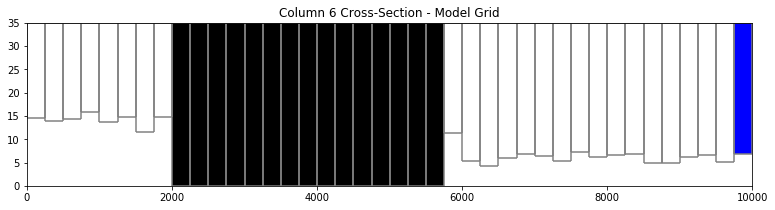

In [4]:
fig = plt.figure(figsize=(13, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the ModelCrossSection class
xsect = flopy.plot.PlotCrossSection(model=dis_ml, line={'Column': 5})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
pc = xsect.plot_ibound()
linecollection = xsect.plot_grid()
t = ax.set_title('Column 6 Cross-Section - Model Grid')

### Backward compatibility with `ModelCrossSection`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/crosssection.py:764: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)


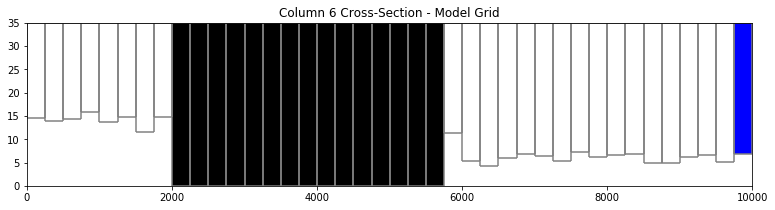

In [5]:
fig = plt.figure(figsize=(13, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the ModelCrossSection class
modelxsect = flopy.plot.ModelCrossSection(model=dis_ml, line={'Column': 5})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
pc = modelxsect.plot_ibound()
linecollection = modelxsect.plot_grid()
t = ax.set_title('Column 6 Cross-Section - Model Grid')

### Plotting a cross sectional model grid for DISV (vertex grid)

since row and column do not exist in the DISV grid, a line must be provided to plot a crosssection. The line can be straight or it can be an arbitrary line across the grid. 

Let's view the line on a MapView plot first

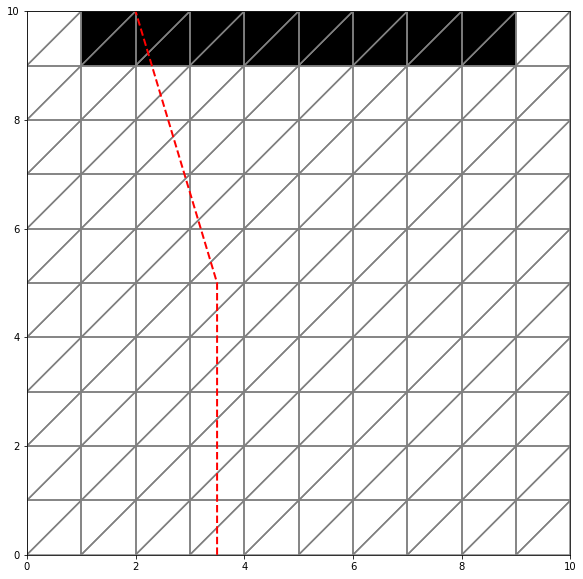

In [6]:
# define a line through the model in model coordiantes as a 
# series of XY vertices where the cross section will be sliced!
line = np.array([(3.5, 0), (3.5, 5), (2, 10)])

fig = plt.figure(figsize=(10, 10))
vmap = PlotMapView(model=disv_ml, layer=0)
ax = vmap.plot_ibound()
pc = vmap.plot_grid()
plt.plot(line[:,0], line[:,1], 'r--', linewidth=2);

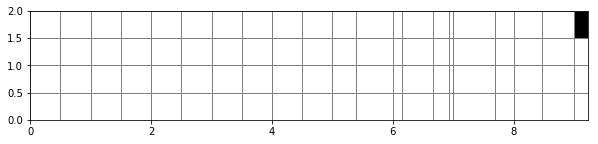

In [7]:
fig = plt.figure(figsize=(10, 2))
xsect = PlotCrossSection(model=disv_ml, line={"line": line})
ax = xsect.plot_ibound()
pc = xsect.plot_grid();

## Plotting arrays of Data:

Plotting arrays can be accomplished using the `plot_array()` method

### Structured grid example (DIS)

In [8]:
# Get data from the head object for plotting
fname = os.path.join(modelpth, 'freyberg.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()

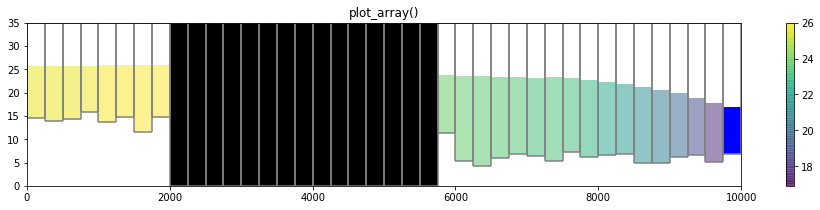

In [9]:
# plot the data
fig = plt.figure(figsize=(16, 3))

plt.title('plot_array()')
xsect = flopy.plot.PlotCrossSection(model=dis_ml, line={'Column': 5})
csa = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
plt.colorbar(csa)

### Backward compatibility with `ModelCrossSection`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/crosssection.py:764: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)


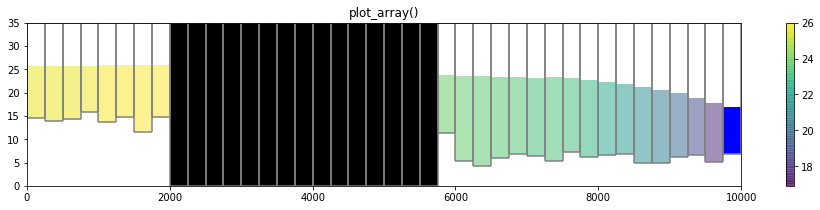

In [10]:
# plot the data
fig = plt.figure(figsize=(16, 3))

plt.title('plot_array()')
xsect = flopy.plot.ModelCrossSection(model=dis_ml, line={'Column': 5})
csa = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
plt.colorbar(csa);

### Vertex grid example (DISV)

The same plotting functionality is available for vertex based model grids. Coming soon is unstructured grid function(s).

In [11]:
hds_file = os.path.join(sim_path, "tri_model.hds")

hds = HeadFile(hds_file)
hdata = hds.get_alldata()[0]
hdata.shape = (disv_ml.modelgrid.nlay, -1)

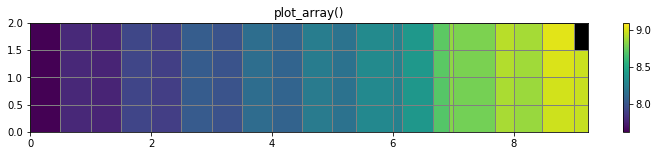

In [12]:
fig = plt.figure(figsize=(12.5, 2))

xsect = PlotCrossSection(model=disv_ml, line={"line": line})

ax = xsect.plot_ibound()
ax = xsect.plot_array(a=hdata, masked_values=[1e30])
plt.colorbar(ax)
xsect.plot_grid()
plt.title("plot_array()");

## Contouring array values on a cross section

By using the `contour_array` method, `PlotCrossSection` is able to draw contour lines using user supplied array data

A surface can also be plotted using the `plot_surface` method

### Structured grid (DIS) example

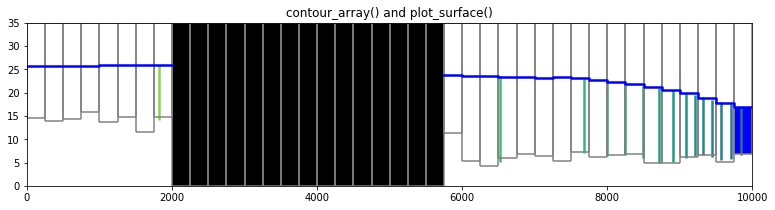

In [13]:
levels = np.arange(10, 30, .5)

fig = plt.figure(figsize=(13, 3))
xsect = flopy.plot.PlotCrossSection(model=dis_ml, line={'Column': 5})

# contour array and plot ibound
ct = xsect.contour_array(head, masked_values=[999.], head=head, levels=levels, linewidths=2.5)
pc = xsect.plot_ibound(head=head)

#plot the surface and model grid
wt = xsect.plot_surface(head, masked_values=[999.], color='blue', lw=2.5)
linecollection = xsect.plot_grid()

plt.title('contour_array() and plot_surface()');

## Backward compatibility with `ModelCrossSection`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/crosssection.py:764: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)


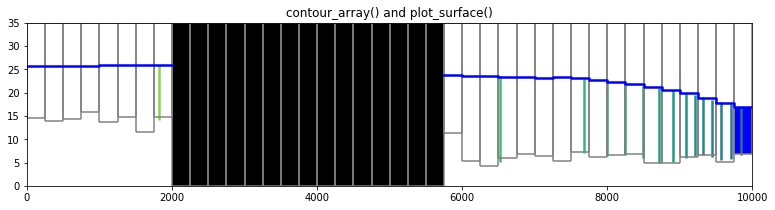

In [14]:
levels = np.arange(10, 30, .5)

fig = plt.figure(figsize=(13, 3))
xsect = flopy.plot.ModelCrossSection(model=dis_ml, line={'Column': 5})

# contour array and plot ibound
ct = xsect.contour_array(head, masked_values=[999.], head=head, levels=levels, linewidths=2.5)
pc = xsect.plot_ibound(head=head)

#plot the surface and model grid
wt = xsect.plot_surface(head, masked_values=[999.], color='blue', lw=2.5)
linecollection = xsect.plot_grid()

plt.title('contour_array() and plot_surface()');

### Vertex grid example (DISV)

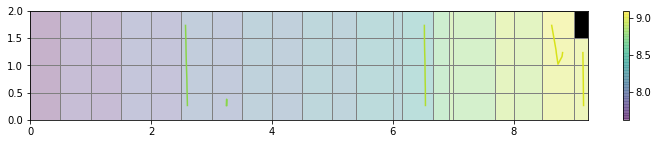

In [15]:
fig = plt.figure(figsize=(12.5, 2))

xsect = PlotCrossSection(model=disv_ml, line={"line": line})
ax = xsect.plot_ibound()
ax = xsect.plot_array(a=hdata, masked_values=[1e30], alpha=0.3)
plt.colorbar(ax)

# set our own contour levels using the matplotlib keyword argument levels
levels = np.arange(1, 10, 0.5)
xsect.contour_array(a=hdata, masked_values=[1e30], levels=levels)

xsect.plot_grid();

## Plotting discharge Vectors

Discharge can be plotted using the `plot_discharge()` method 

### Structured grid example (DIS)

In [16]:
# First let's get the cell budget data
fname = os.path.join(modelpth, 'freyberg.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]

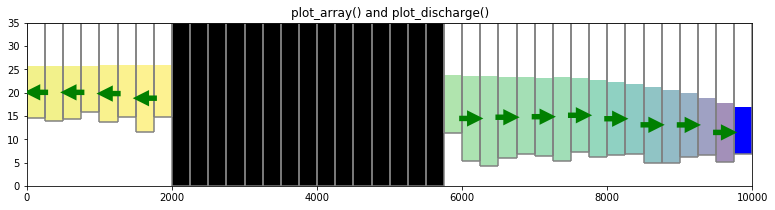

In [17]:
fig = plt.figure(figsize=(13, 3))

plt.title('plot_array() and plot_discharge()')
xsect = flopy.plot.PlotCrossSection(model=dis_ml, line={'Column': 5})
csa = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
linecollection = xsect.plot_grid()
quiver = xsect.plot_discharge(frf, fff, head=head, 
                                   hstep=2, normalize=True, color='green', 
                                   scale=30, headwidth=3, headlength=3, headaxislength=3,
                                   zorder=10)
patches = xsect.plot_ibound(head=head)

### Backward compatibility using `ModelCrossSection`

/Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy/plot/crosssection.py:764: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)


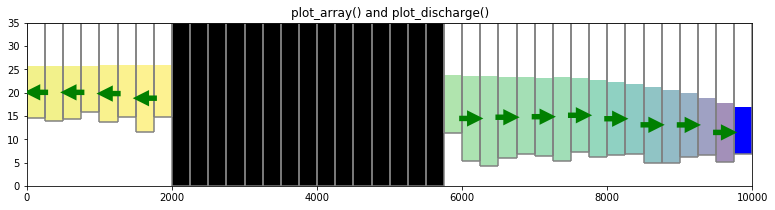

In [18]:
fig = plt.figure(figsize=(13, 3))

plt.title('plot_array() and plot_discharge()')
modelxsect = flopy.plot.ModelCrossSection(model=dis_ml, line={'Column': 5})
csa = modelxsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
linecollection = modelxsect.plot_grid()
quiver = modelxsect.plot_discharge(frf, fff, head=head, 
                                   hstep=2, normalize=True, color='green', 
                                   scale=30, headwidth=3, headlength=3, headaxislength=3,
                                   zorder=10)
patches = modelxsect.plot_ibound(head=head)

### Discharge vector plotting with DISV

The Specific Discharge (SPDIS) recarray is used with plot_specific_discharge to create and plot flow vectors

Specific Discharge can be written to the cell budget file by supplying the option SAVE_SPECIFIC_DISCHARGE in the NPF package of MODFLOW-6 

### Note:
Arbitrary cross section lines cannot be used with this method. A straight cross section must be supplied to calculate discharge vectors.

In [19]:
# Get data from the CellBudgetFile
cbc_file = os.path.join(sim_path, "tri_model.cbc")
cbc = CellBudgetFile(cbc_file, precision='double')
spdis = cbc.get_data(text="SPDIS")



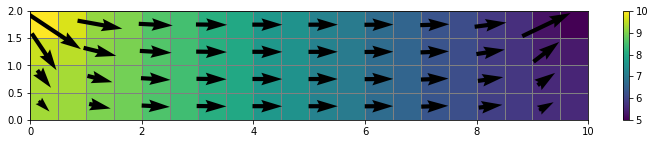

In [20]:
fig = plt.figure(figsize=(12.5, 2))

# define the new cross section line...
line = np.array([(0, 3.5), (10, 3.5)])

vcs = PlotCrossSection(model=disv_ml, line={"line": line})
ax = vcs.plot_array(a=hdata, masked_values=[1e30])
plt.colorbar(ax)
vcs.plot_grid()

# plot discharge vectors
ax = vcs.plot_specific_discharge(spdis, head=hdata, hstep=2)